In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from holisticai.datasets import load_adult
from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

In [3]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [4]:
#X.hist(bins=10, figsize=(10, 10), color = 'mediumslateblue')

<Axes: >

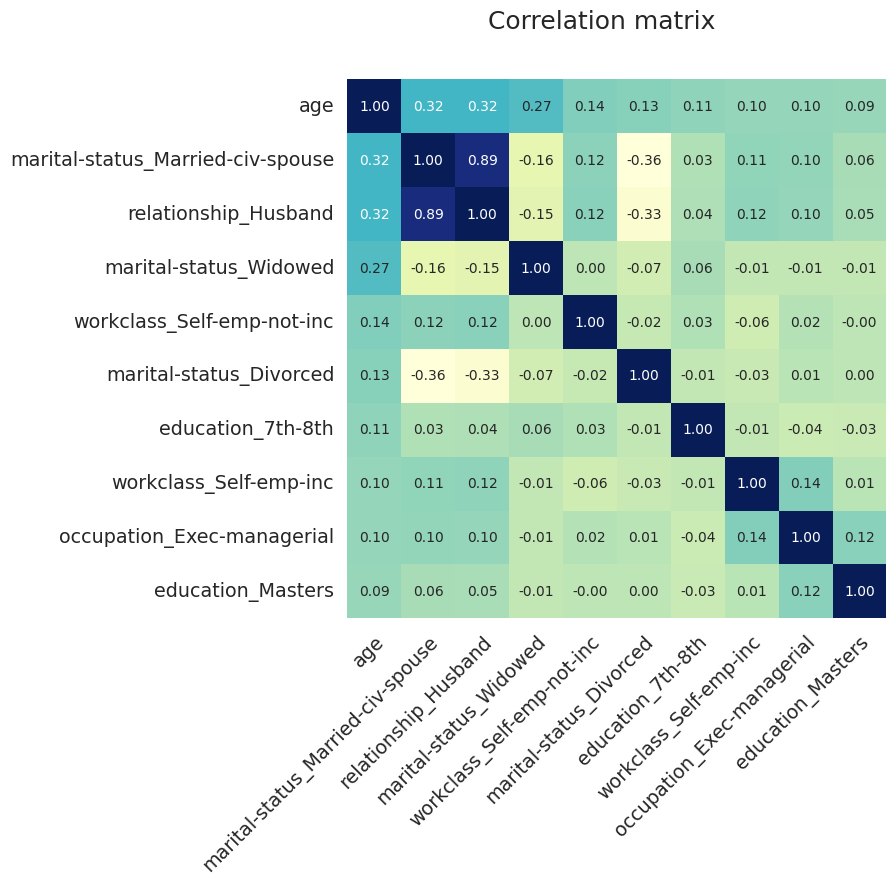

In [5]:
from holisticai.bias.plots import correlation_matrix_plot

correlation_matrix_plot(X, target_feature='age', size = (12,7))

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = GradientBoostingClassifier() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.874399,1
Balanced Accuracy,0.788752,1
Precision,0.793484,1
Recall,0.627511,1
F1-Score,0.700805,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [7]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [8]:
permutation_explainer.metrics()

,Value,Reference
Fourth Fifths,0.408163,0
Importance Spread Divergence,1.070461,-
Importance Spread Ratio,0.766528,0
Global Overlap Score,0.021262,1
Global Range Overlap Score,0.630642,1
Global Similarity Score,0.400110,1
Global Explainability Ease Score,0.984694,1


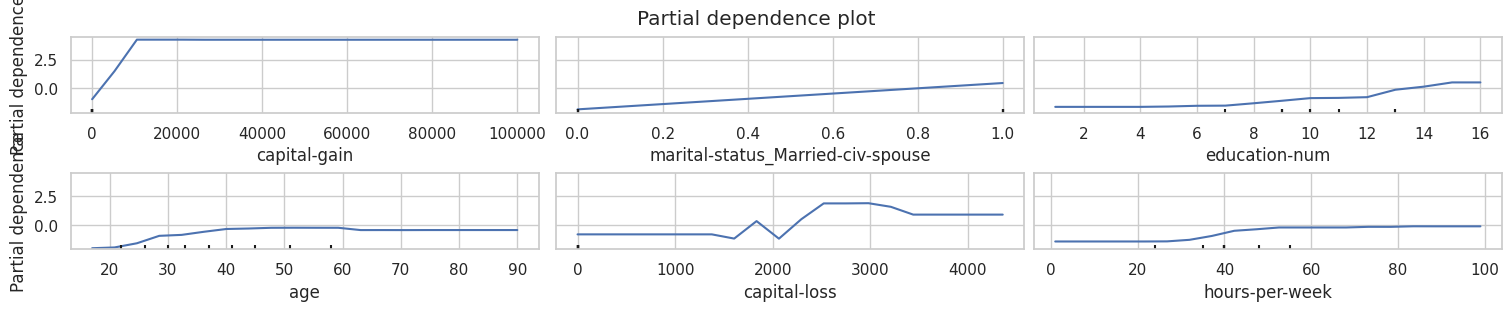

In [30]:
_,ax = plt.subplots(figsize=(15,3))
permutation_explainer.partial_dependence_plot(ax=ax)

In [10]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,0.408163,0
Importance Spread Divergence,1.070461,-
Importance Spread Ratio,0.766528,0
Global Overlap Score [label=0],0.042523,1
Global Overlap Score [label=1],0.000000,1
Global Range Overlap Score [label=0],0.637722,1
Global Range Overlap Score [label=1],0.623563,1
Global Similarity Score [label=0],0.477195,1
Global Similarity Score [label=1],0.323025,1
Global Explainability Ease Score,0.984694,1


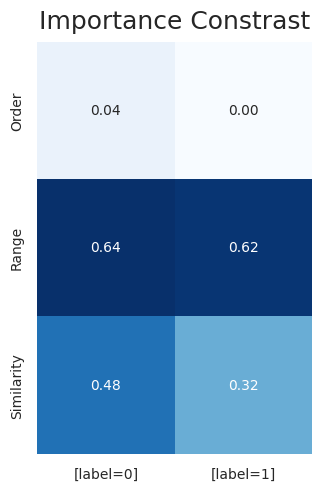

In [11]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

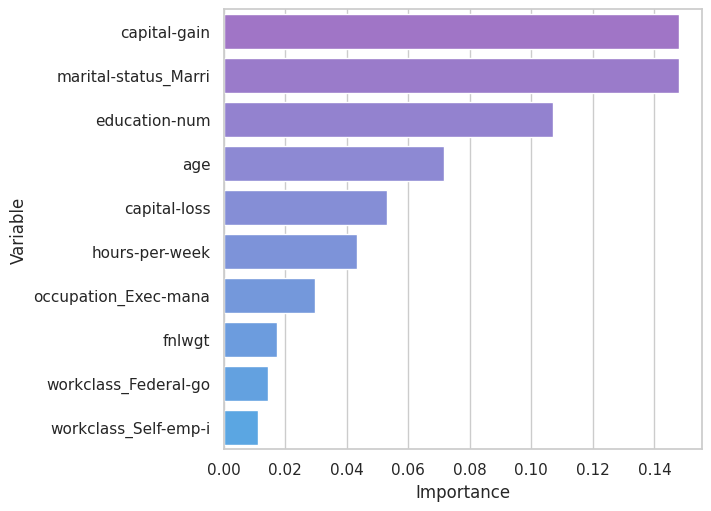

In [12]:
permutation_explainer.bar_plot(max_display=10)

In [13]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.147951,0.013490,0.004927
marital-status_Married-civ-spouse,0.147951,0.020954,0.007245
education-num,0.107091,0.002207,0.007934
age,0.071678,0.039959,0.008751
capital-loss,0.053155,0.016460,0.012227


# Global Explainability metrics (based on Surrogate Model)

In [14]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [15]:
surrogate_explainer.metrics()

,Value,Reference
Fourth Fifths,0.020408,0
Importance Spread Divergence,3.257112,-
Importance Spread Ratio,0.289611,0
Global Explainability Ease Score,0.984694,1
Surrogate Efficacy Classification,0.846280,1


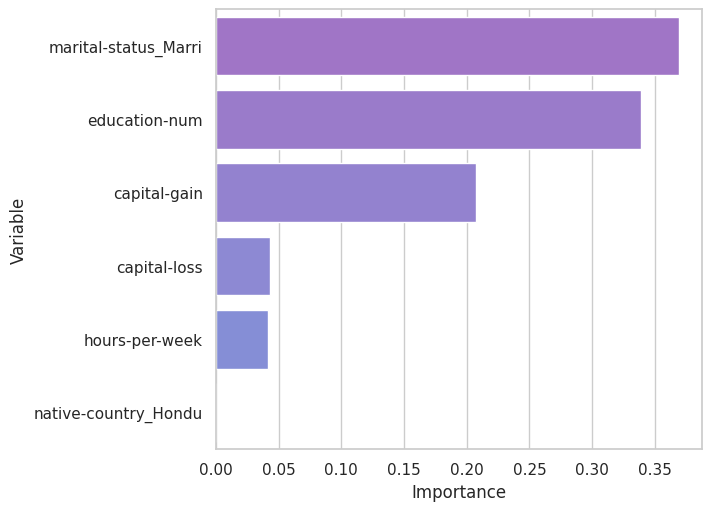

In [16]:
surrogate_explainer.bar_plot(max_display=6)

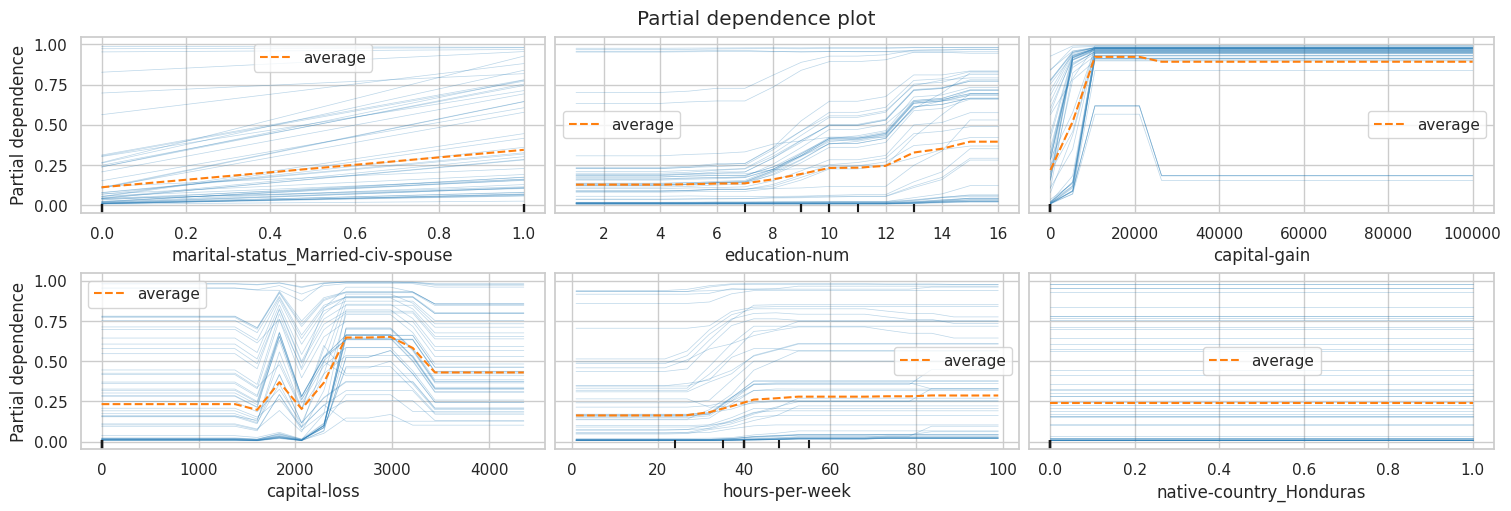

In [17]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

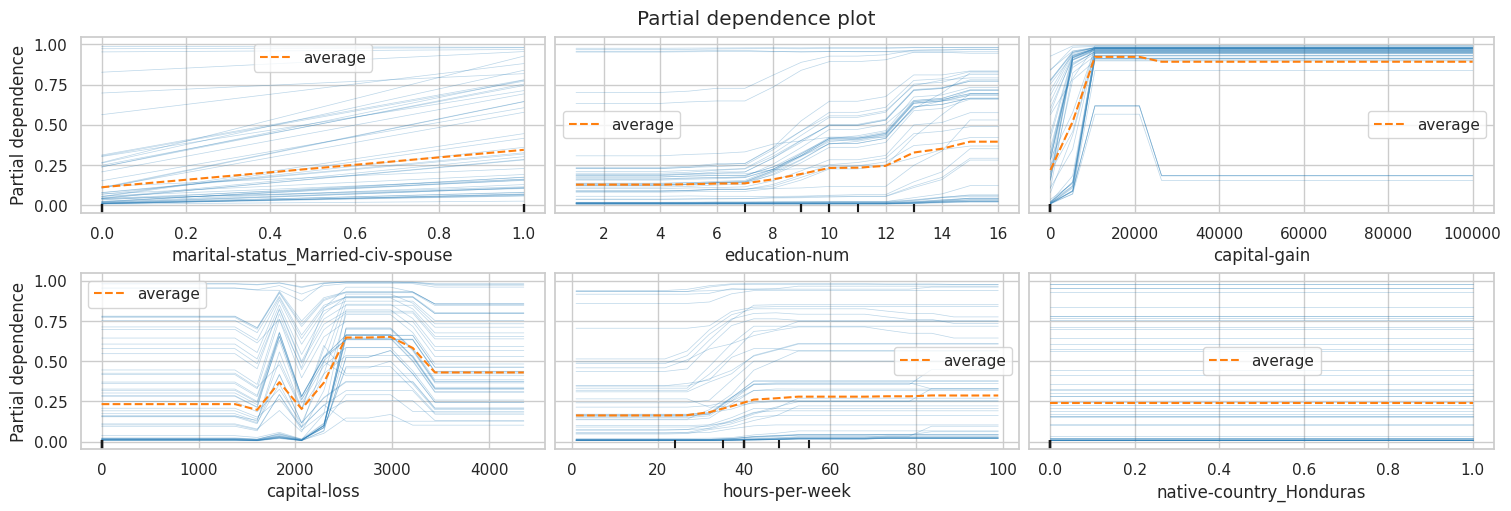

In [18]:
_,ax=plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(ax=ax, kind="both") # kind: [individual,average,both]

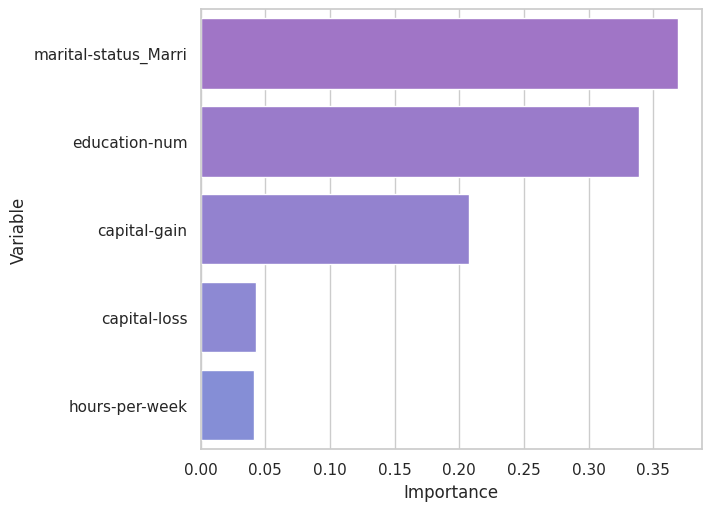

In [19]:
surrogate_explainer.bar_plot(max_display=5)

In [20]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
marital-status_Married-civ-spouse,0.368933
education-num,0.339254
capital-gain,0.207518
capital-loss,0.042951
hours-per-week,0.041345
workclass_Never-worked,0.000000
native-country_Yugoslavia,0.000000
age,0.000000
fnlwgt,0.000000


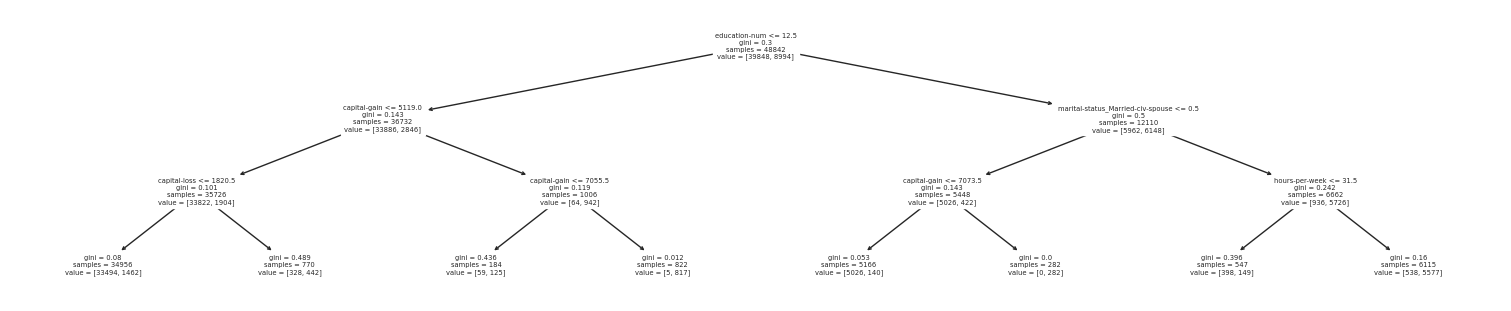

In [21]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

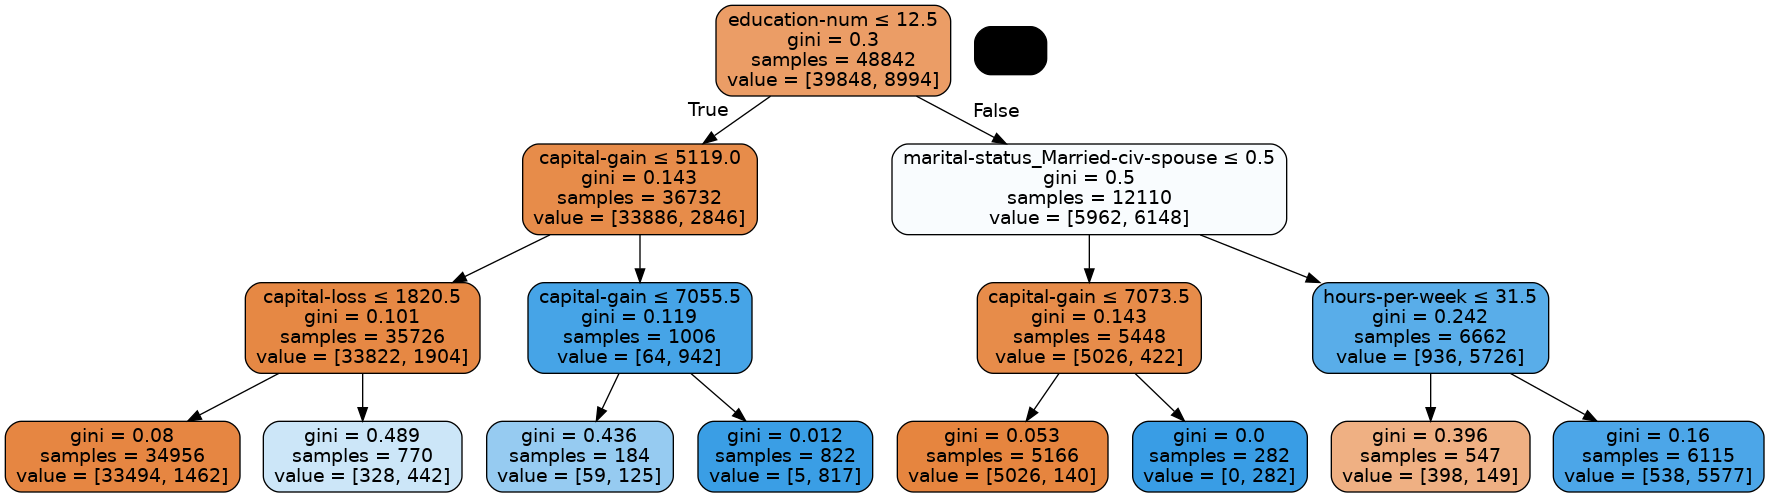

In [22]:
surrogate_explainer.tree_visualization('graphviz')

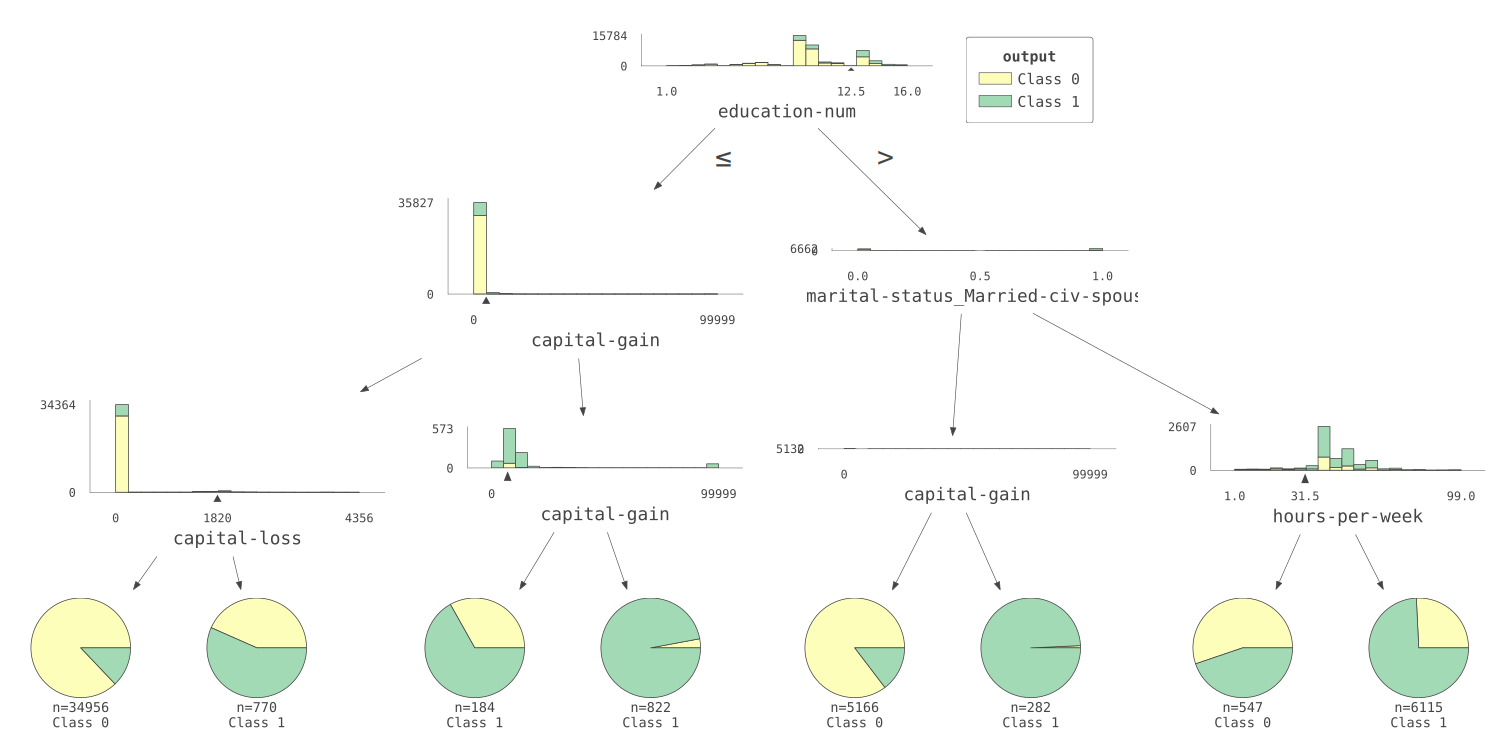

In [23]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [31]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
lime_explainer.metrics(detailed=True)

,value,Reference
Metric,,
Dataset Stability Gini Global,0.019783,0
Dataset Stability Gini [Q0-Q1],0.020000,0
Dataset Stability Gini [Q3-Q4],0.019554,0
Dataset Stability Mean Global,0.772820,0
Dataset Stability Mean [Q0-Q1],0.772538,0
Dataset Stability Mean [Q3-Q4],0.773101,0
Dataset Stability Ratio Global,0.999906,1
Dataset Stability Ratio [Q0-Q1],0.999892,1
Dataset Stability Ratio [Q3-Q4],0.999900,1


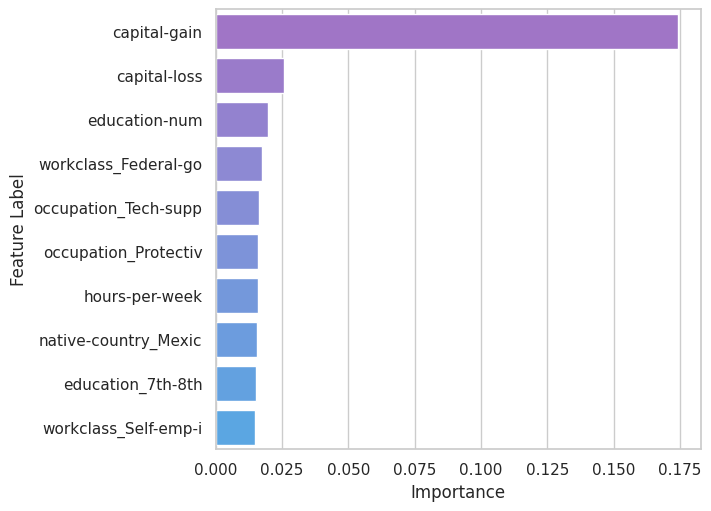

In [ ]:
lime_explainer.bar_plot(max_display=10)

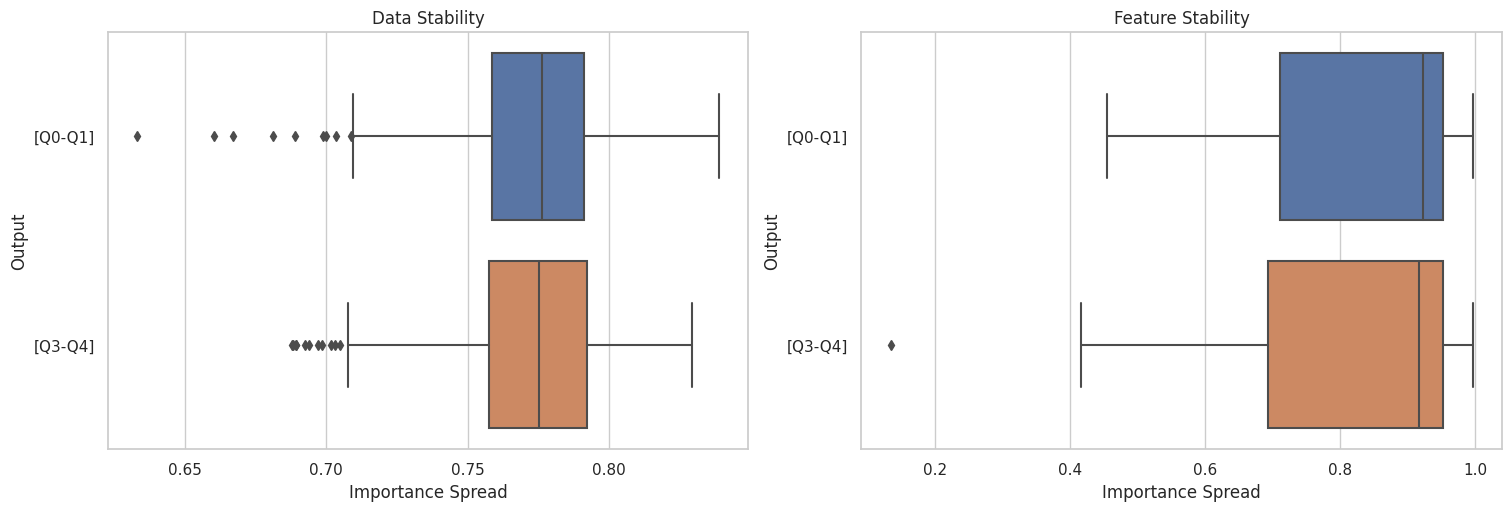

In [32]:
lime_explainer.show_importance_stability()

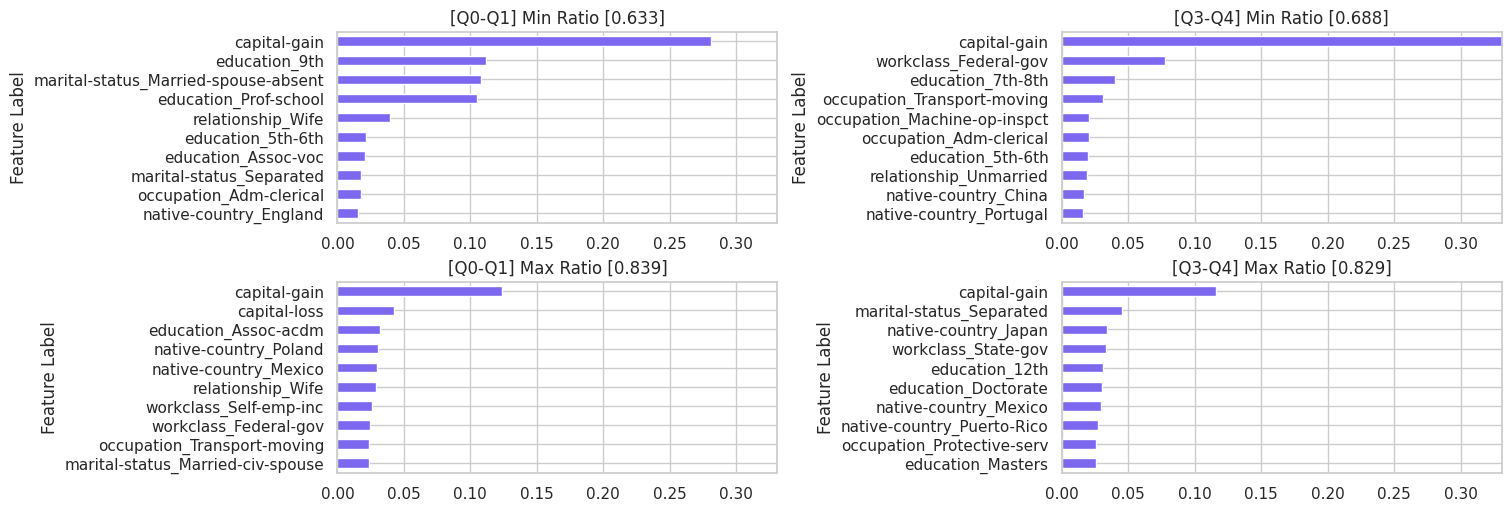

In [33]:
lime_explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

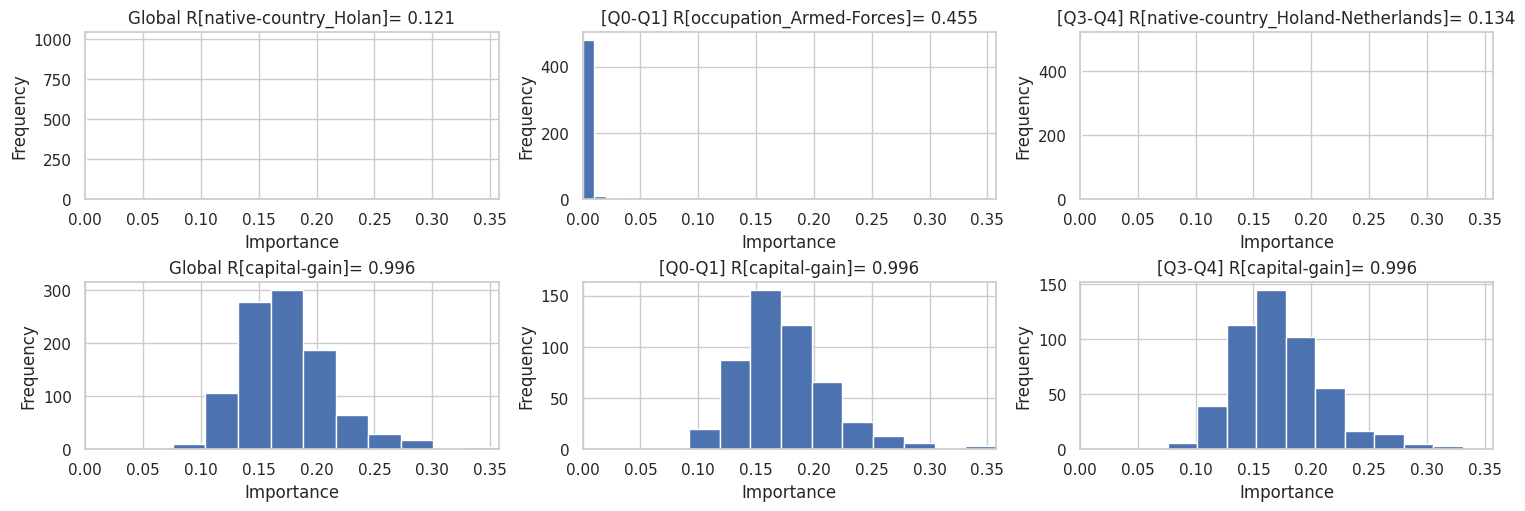

In [34]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))